In [1]:
# importing packages needed for the task
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Functions

In [2]:
def generate_data_and_log_earnings(N, T, sigma, alpha, beta_treatment, beta_age, beta_education, beta_experience, seed=None): 
    ''' Function that generates panel data and returns log-earnings with the parameters of the model.
    
    Parameters:
    -----------
    N (int): Number of individuals in the dataset.
    T (int): Number of time periods.
    sigma (float): Standard deviation of the error term.
    alpha (float) Intercept for the log-earnings model.
    beta_treatment (float): The treatment effect to be applied starting from period 10.
    beta_age (float): Coefficient for the effect of age on log-earnings.
    beta_education (float): Coefficient for the effect of education on log-earnings.
    beta_experience (float): Coefficient for the effect of experience on log-earnings.
    seed (int, optional): Random seed to ensure reproducibility. Default is None.

    Returns:
    --------
    df (pd.DataFrame): A DataFrame containing the panel data with control variables and log-earnings.'''
    
    # setting seed inside the function to ensure reproducibility
    if seed is not None:
        np.random.seed(seed)

    # creating the identifiers for units (id) and time periods (time)
    id = np.repeat(np.arange(1, N + 1), T)
    time = np.tile(np.arange(1, T + 1), N)

    # defining the control variables
    age = np.random.randint(25, 65, size=N * T) # uniform integer distribution between 25 and 65 (plausible ages for working)
    education = np.random.randint(1, 5, size=N * T)  # uniform distribution; education levels represented with a categorical variable (1 to 4: high school, undergrad, grad, phd)
    experience = np.random.randint(1, 40, size=N * T) # uniform integer distribution; experience is measured in terms of the number of years in the workforce

    # half the units receive the treatment, starting from time = 10
    treated_units = np.random.choice(np.arange(1, N + 1), N // 2, replace=False) # treated variables are randomly selected

    # initializing the treatment array with zeros (as no units have received the treatment yet)
    treatment = np.zeros(N * T)
    # looping through each individual and each time period
    for i in range(N):  # loop over individuals
        for t in range(T):  # loop over time periods
            if id[i * T + t] in treated_units and time[t] >= 10: # determining if the individual is in the treated group, previously identified, and if time period is 10 or later (as treatment starts at time = 10)
                treatment[i * T + t] = 1 # assigning treatment value of 1 for treated individuals after time period 10

    # generating log-earnings with the parameters of the model
    delta_i = np.random.normal(0, 0.1, N)  # N individual fixed effects, following a normal distribution N(0,1)
    delta_t = np.random.normal(0, 0.1, T)  # T time fixed effects, following a normal distribution N(0,1)

    # defining the error term
    epsilon = np.random.normal(0, sigma, N * T) # normal distribution (0, sigma^2)

    # generating log earnings
    log_earnings = (
        alpha +
        beta_treatment * treatment +
        beta_age * age +
        beta_education * education +
        beta_experience * experience +
        np.repeat(delta_i, T) + # repeats each individual's fixed effect across T time periods
        np.tile(delta_t, N) + # repeats each time period's fixed effect for N individuals
        epsilon
    )

    # creating the DataFrame with all the relevant columns
    df = pd.DataFrame({
        'id': id,
        'time': time,
        'age': age,
        'education': education,
        'experience': experience,
        'treatment': treatment,
        'log_earnings': log_earnings
    })

    return df

In [3]:
def run_event_study(df, seed=None):
    '''Function that runs the event study estimation and returns treatment effects.

    Parameters:
    -----------
    df (pd.DataFrame): The panel dataset containing individual and time identifiers, control variables, and treatment status.
    seed (int, optional): Random seed to ensure reproducibility. Default is None.

    Returns:
    --------
    summary (statsmodels summary object): A detailed summary of the OLS regression results.
    params (pd.Series): The estimated coefficients for event time dummies, excluding event_time_0.'''
    
    # setting seed for any random operation inside this function
    if seed is not None:
        np.random.seed(seed)

    # creating event time dummies relative to treatment start at time = 10
    df['event_time'] = df['time'] - 10

    # filtering event_time to keep only values from -5 to +5
    df_filtered = df[(df['event_time'] >= -5) & (df['event_time'] <= 5)]

    # creating event time dummies for the filtered event_time
    event_dummies = pd.get_dummies(df_filtered['event_time'], prefix='event_time')
    event_dummies = event_dummies.drop(columns='event_time_0') # dropping the event_time = 0 dummy, which corresponds to the treatment start at time = 10
    event_dummies_numeric = event_dummies.astype(int) # converting bool to 0-1 to correctly perform  regression

    # concatenating event dummies to the filtered DataFrame
    df_filtered = pd.concat([df_filtered, event_dummies_numeric], axis=1)

    # defininf control variables (X) and the dependent variable (y)
    X = df_filtered[['age', 'education', 'experience']].join(event_dummies_numeric)
    y = df_filtered['log_earnings']

    # including individual and time fixed effects
    df_filtered['delta_i'] = df_filtered['id'].astype('category').cat.codes  # individual fixed effects
    df_filtered['delta_t'] = df_filtered['time'].astype('category').cat.codes  # time fixed effects

    # creating the model matrix for fixed effects, with a constant term added
    X_fixed = sm.add_constant(X)
    # running the regression, including individual and time fixed effects
    model = sm.OLS(y, X_fixed).fit(cov_type='HC1')  # using heteroskedasticity-consistent standard errors

    return [model.summary(), model.params[event_dummies.columns]]

## 2. Data Simulation

In [4]:
# setting the master seed for reproducibility
master_seed = 67

# setting the parameters for the study
N = 500  # number of individuals
T = 15   # number of time periods
alpha = 5  # intercept
beta_treatment = 0.2  # treatment effect
beta_age = 0.03  # effect of age
beta_education = 0.1  # effect of education
beta_experience = 0.05  # effect of experience
sigma = 0.5  # standard deviation of the error term

In [5]:
# simulating panel data and finding log_earnings
df = generate_data_and_log_earnings(N, T, sigma, alpha, beta_treatment, beta_age, beta_education, beta_experience, seed = master_seed)
df

,id,time,age,education,experience,treatment,log_earnings
0,1,1,28,2,36,0.0,8.611707
1,1,2,35,3,27,0.0,7.423821
2,1,3,30,4,38,0.0,8.731598
3,1,4,32,4,33,0.0,7.900930
4,1,5,50,4,25,0.0,9.384448
...,...,...,...,...,...,...,...
7495,500,11,46,1,4,0.0,6.698093
7496,500,12,42,3,38,0.0,8.769813
7497,500,13,46,3,6,0.0,6.408161
7498,500,14,55,1,29,0.0,8.226103


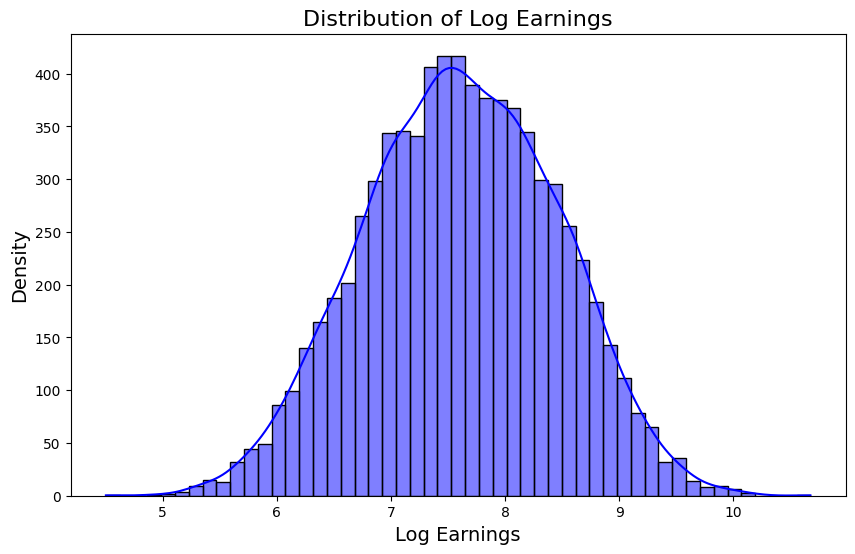

In [6]:
# plotting the distribution of log_earnings to check if it correctly follows a normal distribution
plt.figure(figsize=(10, 6))

# histogram with a kernel density estimate (KDE) overlaid
sns.histplot(df['log_earnings'], kde=True, color='blue')

# adding labels and title for clarity
plt.title('Distribution of Log Earnings', fontsize=16)
plt.xlabel('Log Earnings', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.show()

In [7]:
# checking that the DataFrame has been correctly created
df.head(20)

,id,time,age,education,experience,treatment,log_earnings
0,1,1,28,2,36,0.0,8.611707
1,1,2,35,3,27,0.0,7.423821
2,1,3,30,4,38,0.0,8.731598
3,1,4,32,4,33,0.0,7.900930
4,1,5,50,4,25,0.0,9.384448
5,1,6,34,2,19,0.0,7.423843
6,1,7,52,1,25,0.0,8.347562
7,1,8,60,1,9,0.0,7.458201
8,1,9,47,3,14,0.0,8.331016
9,1,10,50,3,12,0.0,7.255223


In [8]:
# exporting the simulated dataset to a CSV file
df.to_csv('simulated_dataset.csv', index=False)

## 3. Event Study Estimation

In [9]:
# running the event study for the simulated dataset
treatment_effects_summary, treatment_params = run_event_study(df, seed=master_seed)

In [10]:
# visualizing the treatment effects summary
treatment_effects_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnings   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     686.7
Date:                Thu, 26 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:32:49   Log-Likelihood:                -4189.1
No. Observations:                5500   AIC:                             8406.
Df Residuals:                    5486   BIC:                             8499.
Df Model:                          13                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.9045      0.042    117.596      0.000       4.823       4.986
age               0.0289      0.001     47.205      0.000       0.028       0.030
education         0.1099      0.006     17.269      0.000       0.097       0.122
experience        0.0493      0.001     78.401      0.000       0.048       0.051
event_time_-5     0.2401      0.032      7.588      0.000       0.178       0.302
event_time_-4     0.2973      0.033      9.031      0.000       0.233       0.362
event_time_-3     0.0869      0.032      2.684      0.007       0.023       0.150
event_time_-2     0.2245      0.033      6.802      0.000       0.160       0.289
event_time_-1     0.2208      0.031      7.094      0.000       0.160       0.282
event_time_1      0.1882      0.033      5.744      0.000       0.124       0.252
event_time_2      0.1630      0.033      4.889      0.000       0.098       0.228
event_time_3      0.1234      0.033      3.762      0.000       0.059       0.188
event_time_4      0.2120      0.034      6.252      0.000       0.146       0.278
event_time_5      0.0948      0.033      2.862      0.004       0.030       0.160
==============================================================================
Omnibus:                        1.759   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.415   Jarque-Bera (JB):                1.764
Skew:                          -0.044   Prob(JB):                        0.414
Kurtosis:                       2.993   Cond. No.                         581.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [11]:
# saving the event study results (coefficients and standard errors)
with open('event_study_summary.txt', 'w') as f:
    f.write(str(treatment_effects_summary))

## 4. Monte Carlo Simulations

In [12]:
num_simulations = 1000  # setting the parameter for the number of simulations

# Monte Carlo simulation loop
treatment_effects = []
for i in range(num_simulations):
    current_seed = master_seed + i
    df = generate_data_and_log_earnings(N, T, sigma, alpha, beta_treatment, beta_age, beta_education, beta_experience, seed = current_seed)  # resetting seed for each iteration to ensure reproducibility; +i leads each simulation to use a slightly different seed
    
    # running event study and recording treatment effects
    _, treatment_params = run_event_study(df, seed = current_seed)
    treatment_effects.append(treatment_params)

# converting treatment effects into a DataFrame, excluding time 0 (baseline)
treatment_effects_df = pd.DataFrame(treatment_effects, columns=[f'event_time_{i}' for i in range(-5, 6) if i!= 0])

# analyzing treatment effects
print(treatment_effects_df.describe())

       event_time_-5  event_time_-4  event_time_-3  event_time_-2  \
count    1000.000000    1000.000000    1000.000000    1000.000000   
mean       -0.104449      -0.098660      -0.099724      -0.101965   
std         0.147607       0.148220       0.146105       0.151384   
min        -0.557303      -0.521196      -0.569140      -0.516138   
25%        -0.201293      -0.202132      -0.197148      -0.203768   
50%        -0.102751      -0.098268      -0.098388      -0.102423   
75%        -0.010585       0.003586      -0.001599       0.002727   
max         0.341796       0.420745       0.419371       0.355800   

       event_time_-1  event_time_1  event_time_2  event_time_3  event_time_4  \
count    1000.000000   1000.000000   1000.000000   1000.000000   1000.000000   
mean       -0.100642     -0.003846     -0.000005     -0.007041     -0.000177   
std         0.149857      0.146796      0.145779      0.140570      0.145598   
min        -0.495103     -0.423767     -0.404353     -0.46

In [13]:
# summarizing Monte Carlo results (mean and standard deviation of estimates)
monte_carlo_summary = treatment_effects_df.describe().loc[['mean', 'std']]

# exporting Monte Carlo summary to CSV
monte_carlo_summary.to_csv('monte_carlo_summary.csv')

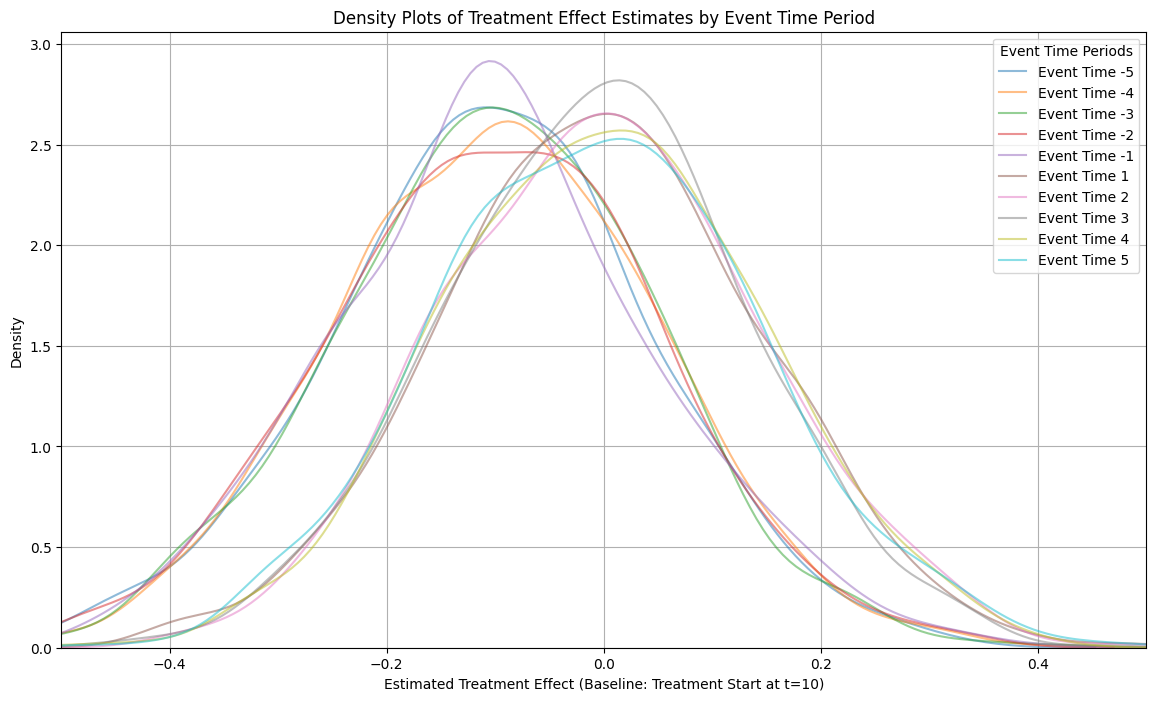

In [14]:
plt.figure(figsize=(14, 8))

# defining the event time periods, excluding 0 as it is the baseline period
event_time_periods = [i for i in range(-5, 6) if i != 0]

# creating density plots for each event time period
for period in event_time_periods:
    sns.kdeplot(treatment_effects_df[f'event_time_{period}'], label=f'Event Time {period}', fill=False, alpha=0.5)

# customizing the plot
plt.title('Density Plots of Treatment Effect Estimates by Event Time Period')
plt.xlabel('Estimated Treatment Effect (Baseline: Treatment Start at t=10)')
plt.ylabel('Density')
plt.legend(title='Event Time Periods')
plt.grid()
plt.xlim(-0.5, 0.5)  # setting x-axis limits for better visualization
plt.savefig(f'density_plot_event_time.png') # saving the plot
plt.show()
plt.close()